In [113]:
import numpy as np
import math
import heapq

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt
from a_star import maze_plot
import pickle
from shapely.geometry import Polygon, LineString
from shapely.geometry import Point
from magic import ordinator


In [114]:
with open(r"SLAM20240124_101335.pickle", "rb") as input_file:
    e = pickle.load(input_file)

positions = e['positions']
ids = e['ids']

positions_array = np.array(positions)
positions_array = np.array(positions)

mask_external = (ids % 3 == 2) & (ids >= 100) & (ids <= 1000)
mask_internal = (ids % 3 == 0) & (ids >= 100) & (ids <= 1000)

ids_external = ids[mask_external]
ids_internal = ids[mask_internal]

positions_external = positions_array[mask_external]
positions_internal = positions_array[mask_internal]


pos_list_ext = [pos for pos in positions_external]
pos_list_int = [pos for pos in positions_internal]

external_ordered = np.array(ordinator(pos_list_ext,max_distance=0.6))
internal_ordered = np.array(ordinator(pos_list_int))

spatial_step=0.03
max_x=np.max(external_ordered[:,0])
max_y=np.max(external_ordered[:,1])
min_x=np.min(external_ordered[:,0])
min_y=np.min(external_ordered[:,1])
delta_x=max_x-min_x
delta_y=max_y-min_y
center_x=min_x+delta_x/2
center_y=min_y+delta_y/2

n_x = int(delta_x/spatial_step/1.5)
n_y = int(delta_y/spatial_step/1.5)

ext_ordered_poly = Polygon(external_ordered)
int_ordered_poly = Polygon(internal_ordered)

x = np.linspace(min(np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), max(
    np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), n_x)
y = np.linspace(min(np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), max(
    np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), n_y)
X, Y = np.meshgrid(x, y)

# Create a mask where the pixels inside the first circle and outside the second circle are set to 1, and all others are set to 0
mask = np.array([[ext_ordered_poly.contains(Point(x[i], y[j])) and not int_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])

mask = 1-mask

Missing 2 nodes to close the polygon; min_dist = 2.5830176518299472
Missing 1 nodes to close the polygon; min_dist = 0.70293141703667


In [115]:
# Define the number of checkpoints
num_checkpoints = 5

# Get the coordinates of the external polygon
coords = external_ordered.tolist()

# Create a LineString object from the coordinates
line = LineString(coords)

# Calculate the total length of the line
total_length = line.length

# Calculate the spacing between checkpoints
spacing = total_length / (num_checkpoints - 1)

# Generate the checkpoints
checkpoints = []
for i in range(num_checkpoints):
    # Calculate the distance along the line
    dist = i * spacing

    # Find the point at this distance along the line
    checkpoint = line.interpolate(dist)

    # Convert the point to a tuple and add it to the list of checkpoints
    checkpoints.append(tuple(checkpoint.coords[0]))

print(checkpoints)

[(0.38843462369917703, -0.29210255312100625), (-0.288022607301126, 1.692871959054671), (-2.1506122259138, 1.1547794783382601), (-0.9258812765071667, -0.9054430632720127), (0.5450499317743625, -0.41276500060284327)]


In [116]:
# ext_ordered_line = LineString(external_ordered)  # Create a LineString for interpolation

# def interpolate_points(line, interval):
#     num_points = int(line.length / interval)
#     points = [line.interpolate(distance) for distance in np.linspace(0, line.length, num_points)]
#     return np.array([[point.x, point.y] for point in points])


# interval = 2
# # Interpolate points along the external boundary
# checkpoints = interpolate_points(ext_ordered_line, interval)

# print(len(checkpoints))
# # print(checkpoints)

In [117]:
# Transform coordinates into the mask cooordinate system
transformed_checkpoints = []
for cp in checkpoints:
    # Map real-world coordinates to mask indices
    ix = np.argmin(np.abs(x - cp[0]))
    iy = np.argmin(np.abs(y - cp[1]))
    transformed_checkpoints.append((ix, iy))


def adjust_checkpoint(checkpoint, maze, step_size=4):
    """
    Move the checkpoint towards the center of the maze until it is on a steppable area.
    :param checkpoint: The original checkpoint coordinates (tuple).
    :param maze: The 2D maze array.
    :param step_size: The step size towards the center.
    :return: Adjusted checkpoint coordinates (tuple).
    """
    max_y, max_x = maze.shape  # Assuming maze is a 2D numpy array
    center_x, center_y = max_x // 2, max_y // 2

    adjusted_x, adjusted_y = checkpoint

    while maze[adjusted_y, adjusted_x] != 0:
        # Move the checkpoint towards the center
        if adjusted_x < center_x:
            adjusted_x += step_size
        elif adjusted_x > center_x:
            adjusted_x -= step_size

        if adjusted_y < center_y:
            adjusted_y += step_size
        elif adjusted_y > center_y:
            adjusted_y -= step_size

        # Check bounds
        adjusted_x = max(0, min(adjusted_x, max_x - 1))
        adjusted_y = max(0, min(adjusted_y, max_y - 1))

        # If already at center or cannot move further, break
        if (adjusted_x == center_x and adjusted_y == center_y) or maze[adjusted_y, adjusted_x] == 0:
            break

    return adjusted_x, adjusted_y

adjusted_checkpoints = [adjust_checkpoint(checkpoint, mask) for checkpoint in transformed_checkpoints]

# def filter_close_checkpoints(checkpoints, min_distance):
#     filtered_checkpoints = []
#     for i in range(len(checkpoints) - 1):
#         if np.linalg.norm(np.array(checkpoints[i]) - np.array(checkpoints[i+1])) >= min_distance:
#             filtered_checkpoints.append(checkpoints[i])
#     filtered_checkpoints.append(checkpoints[-1])  # Always include the last checkpoint
#     return filtered_checkpoints

print("Adjusted checkpoints:",adjusted_checkpoints)

# filtered_adjusted_checkpoints = filter_close_checkpoints(adjusted_checkpoints, 7)

# print("Filtered adjusted checkpoints:", filtered_adjusted_checkpoints)

Adjusted checkpoints: [(56, 27), (38, 66), (5, 55), (28, 14), (56, 28)]


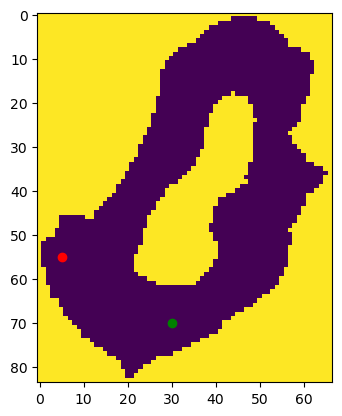

(84, 67)

In [118]:
start = (30,70)

##############################
# Sorting the checkpoints!!
##############################

# distances = [np.sqrt((cp[0]-start[0])**2 + (cp[1]-start[1])**2) for cp in adjusted_checkpoints]
# # Pair each checkpoint with its distance from the start point
# checkpoints_with_distances = list(zip(adjusted_checkpoints, distances))

# # Sort the checkpoints based on their distance from the start point
# sorted_checkpoints = sorted(checkpoints_with_distances, key=lambda x: x[1])

# # Extract the sorted checkpoints
# sorted_checkpoints = [cp[0] for cp in sorted_checkpoints]


plt.imshow(mask, interpolation='nearest', origin='upper')
# plt.axvline(center_x, color='blue')
plt.scatter(start[0], start[1], color='green',)
# for checkpoint in adjusted_checkpoints:
#     plt.scatter(checkpoint[0], checkpoint[1], color='red')
# # plt.scatter(center_x, center_y, color='blue')
i = 2
# plt.scatter(sorted_checkpoints[i][0], sorted_checkpoints[i][1], color="red")
plt.scatter(adjusted_checkpoints[i][0], adjusted_checkpoints[i][1], color="red")

plt.show()
mask.shape

In [119]:
def heuristic_(a, b):
    # Chebyshev distance
    (x1, y1) = a
    (x2, y2) = b
    return max(abs(x1 - x2), abs(y1 - y2))

def astar(maze, start, end):
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0),
             (1, 1), (-1, -1), (-1, 1), (1, -1)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic_(start, end)}
    oheap = []
    open_set_hash = set([start])  # To check efficiently if a node is in the open set

    def neighbors_available(position):
        neighbors = []
        for move in moves:
            x_test, y_test = position[0] + move[0], position[1] + move[1]
            if 0 <= x_test < maze.shape[0] and 0 <= y_test < maze.shape[1]:
                if maze[x_test, y_test] != 1:
                    neighbors.append((x_test, y_test))
        return neighbors

    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]
        open_set_hash.remove(current)

        if current == end:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data[::-1]  # Reversing the path

        close_set.add(current)
        for neighbor in neighbors_available(current):
            tentative_g_score = gscore[current] + 1

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in open_set_hash:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic_(neighbor, end)
                if neighbor not in open_set_hash:
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))
                    open_set_hash.add(neighbor)

    return False

def astar_with_checkpoints(maze, start, checkpoints):
    path = []
    current_start = start

    for checkpoint in checkpoints:
        segment = astar(maze, current_start, checkpoint)
        if segment:
            path.extend(segment)
            current_start = checkpoint
        else:
            print(f"Path not found for segment to checkpoint {checkpoint}")
            return None  # Path not found for a segment

    # Optional: return to start
    return_to_start_segment = astar(maze, current_start, start)
    if return_to_start_segment:
        path.extend(return_to_start_segment)

    return path


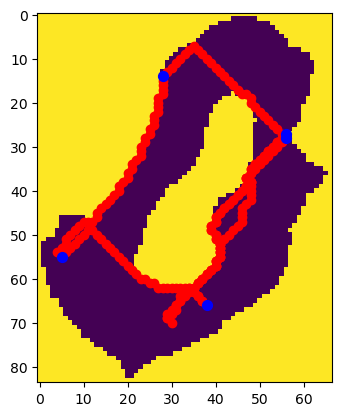

[(30, 70), (29, 69), (29, 68), (30, 67), (31, 66), (32, 65), (33, 64), (34, 63), (35, 62), (36, 61), (37, 60), (38, 59), (39, 58), (40, 57), (40, 56), (41, 55), (41, 54), (41, 53), (41, 52), (40, 51), (40, 50), (39, 49), (39, 48), (40, 47), (40, 46), (41, 45), (42, 44), (43, 43), (44, 42), (45, 41), (46, 40), (47, 39), (48, 38), (47, 37), (48, 36), (49, 35), (50, 34), (51, 33), (52, 32), (53, 31), (54, 30), (55, 29), (56, 28), (55, 27), (54, 26), (53, 25), (52, 24), (51, 23), (50, 22), (49, 21), (48, 20), (48, 19), (47, 18), (46, 18), (45, 17), (44, 16), (43, 15), (42, 14), (41, 13), (40, 12), (39, 11), (38, 10), (37, 9), (36, 8), (35, 7), (34, 8), (33, 9), (32, 10), (31, 11), (30, 12), (29, 13), (28, 14), (28, 15), (28, 16), (28, 17), (28, 18), (27, 19), (27, 20), (27, 21), (27, 22), (26, 23), (26, 24), (26, 25), (25, 26), (25, 27), (24, 28), (24, 29), (23, 30), (23, 31), (23, 32), (22, 33), (21, 34), (21, 35), (20, 36), (20, 37), (19, 38), (18, 39), (18, 40), (17, 41), (16, 42), (15,

In [120]:
def maze_plot_with_checkpoints(maze, start, checkpoints):
    # Adjusting the start and checkpoints for the coordinate system of the maze
    adjusted_start = start[::-1]  # If necessary, adjust this according to your maze's coordinate system
    adjusted_checkpoints = [checkpoint[::-1] for checkpoint in checkpoints]  # Adjusting checkpoints

    # Using the modified A* function for checkpoints
    full_path = astar_with_checkpoints(maze, adjusted_start, adjusted_checkpoints)
    if full_path is None:
        print("Path not found")
        return

    plt.imshow(maze, origin='upper')

    # Plot the path
    for point in full_path:
        plt.scatter(point[1], point[0], color='red')  # Ensure correct order for x, y plotting

    # Plot the checkpoints
    for checkpoint in checkpoints:
        plt.scatter(checkpoint[0], checkpoint[1], color='blue', s=50)  # Mark checkpoints in blue

    plt.show()
    
    # Convert path back to original coordinate system if necessary
    full_path = [(x[1], x[0]) for x in full_path]
    print(full_path[::-1])  # Print the path in the original coordinate system


maze_plot_with_checkpoints(mask, start, adjusted_checkpoints)